In [1]:
from dataloader import PriceScenarioDataset
from utils import VaR, ES, score
from Discriminator import Discriminator
from Generator import Generator
from Tradining_Strategies import TradingStrategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from preprocess.acf import *
# from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from model.torch_tcn import *

In [2]:
num_epochs = 100
# nz = 3
batch_size = 64
#seq_len = 127
# clip= 0.01
lr = 0.002

noise_size=10
pnl_size=100
market_size=5

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev) 

In [3]:
data_df = pd.read_csv("./data/Portfolios_Formed_on_ME_daily.csv", error_bad_lines=False)

C:\Users\ytc19\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x)[0]

'0.39'

In [8]:
lo30_df=data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x).apply(float)
lo30_data=lo30_df.to_numpy(dtype=np.float32).reshape(1,-1)
lo30_data = torch.tensor(lo30_data,)
dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
for i in dataloader:
    print(i[0].shape,i[-1].shape)
    break
len(dataset)

torch.Size([64, 1, 100]) torch.Size([64, 1, 100])


50575

In [6]:
torch.ones_like(torch.tensor((2,1))).shape

torch.Size([2])

In [ ]:
(b*1*pnl)

In [7]:
import torch.optim as optim
from tqdm import tqdm

generator = Generator(noise_size=noise_size,
                      pnl_size=pnl_size,market_size=batch_size
                     ).to(device)

train = True

trade_strategy = TradingStrategy("buy-hold",0,(0,0),(0,0))

if train:
    discriminator = Discriminator(pnl_size=pnl_size).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
            
            discriminator.zero_grad()
            ps_real = data[0].reshape(batch_size,-1)
#             score_real = data[-1].reshape(batch_size,-1)
            
            ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()
            
            ts_real = trade_strategy._get_strategy_PnL(ps_real,torch.ones_like(ps_real))
            ts_fake = trade_strategy._get_strategy_PnL(ps_fake,torch.ones_like(ps_fake))
            
            fake_ve = discriminator(ts_fake)
            fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
            real_ve = discriminator(ts_real)
            real_v,real_e = real_ve[:,0],real_ve[:,1]
            
            disc_loss = torch.mean(score(fake_v,fake_e,ps_fake,1)) - \
                                  torch.mean(score(real_v,real_e,ps_real,1))
                                            
            disc_loss.backward()
                                    
            disc_optimizer.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                ts_fake = trade_strategy._get_strategy_PnL(ps_fake,torch.ones_like(ps_fake))

                fake_ve = discriminator(ts_fake)
                fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

                gen_loss = -torch.mean(score(fake_v,fake_e,ps_fake,1))
                                            
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'./trained_generator_{}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 1

## Generate

In [8]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

75

## Results and visualizing stylized facts

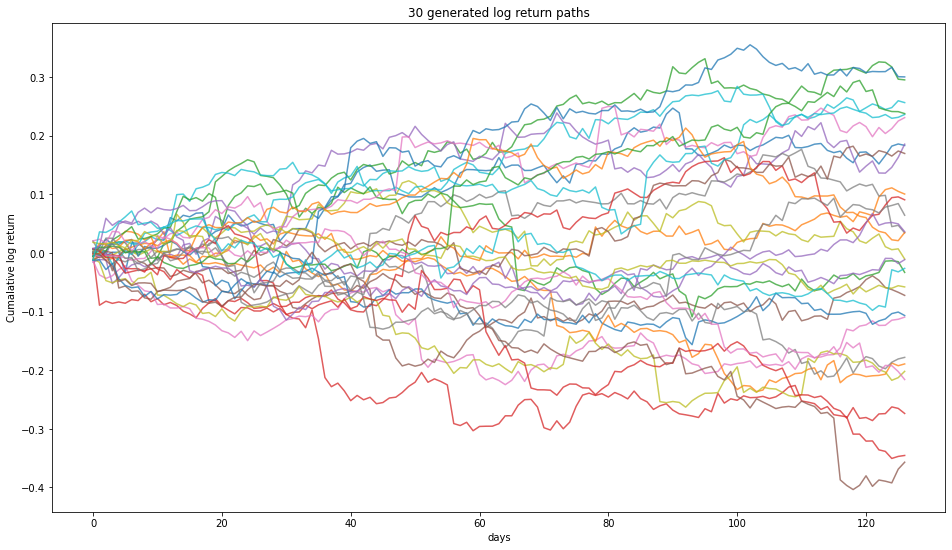

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

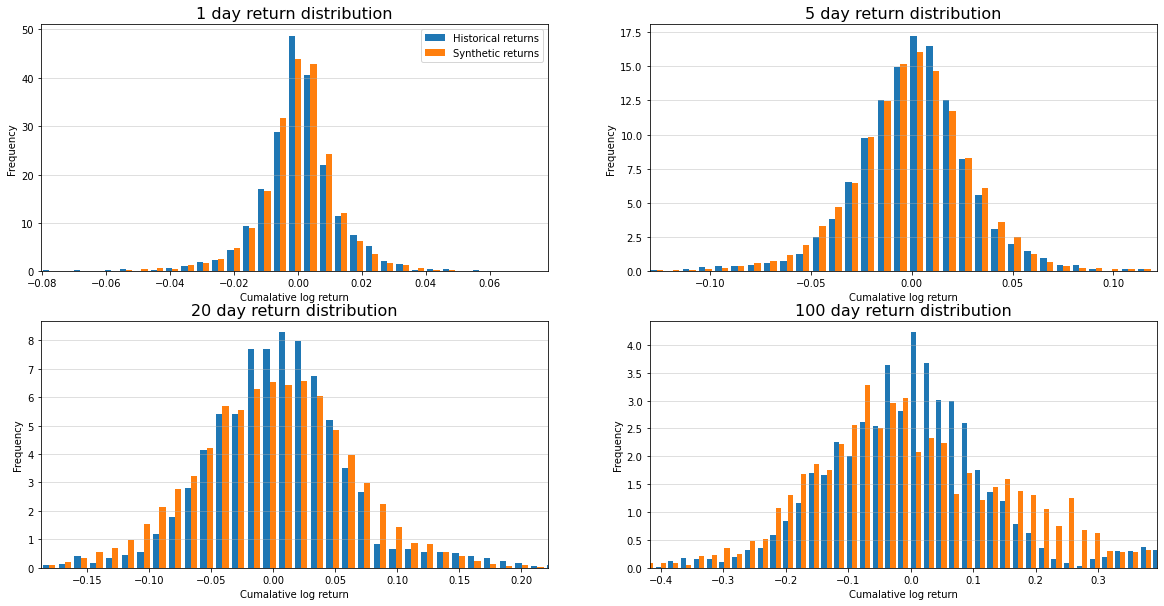

In [10]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

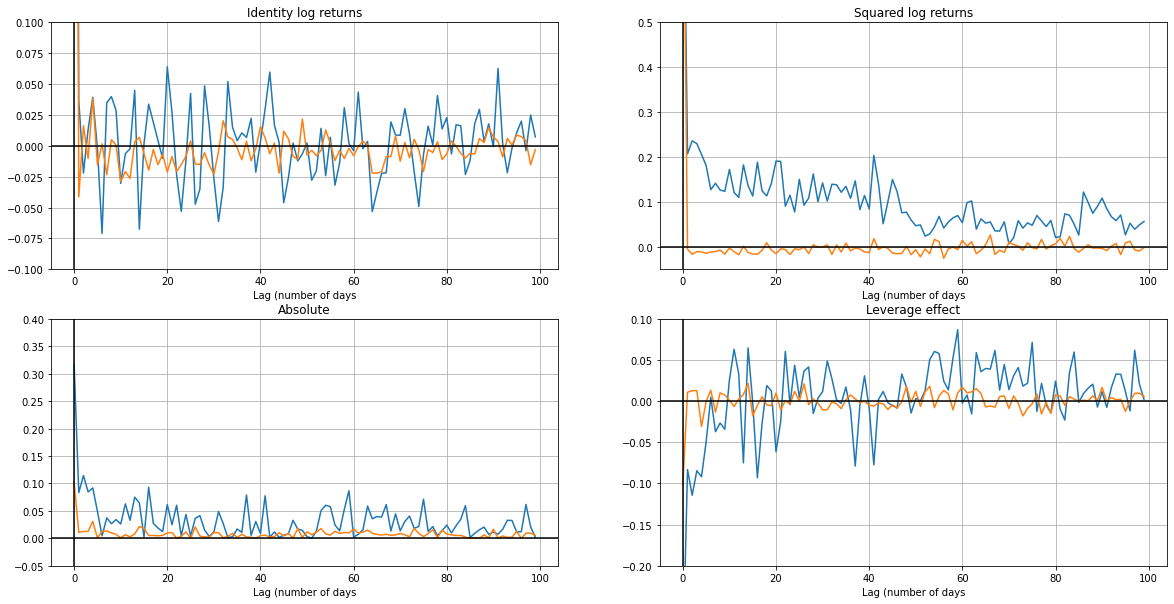

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')